# Finding Heavy Traffic Indicators on I-94

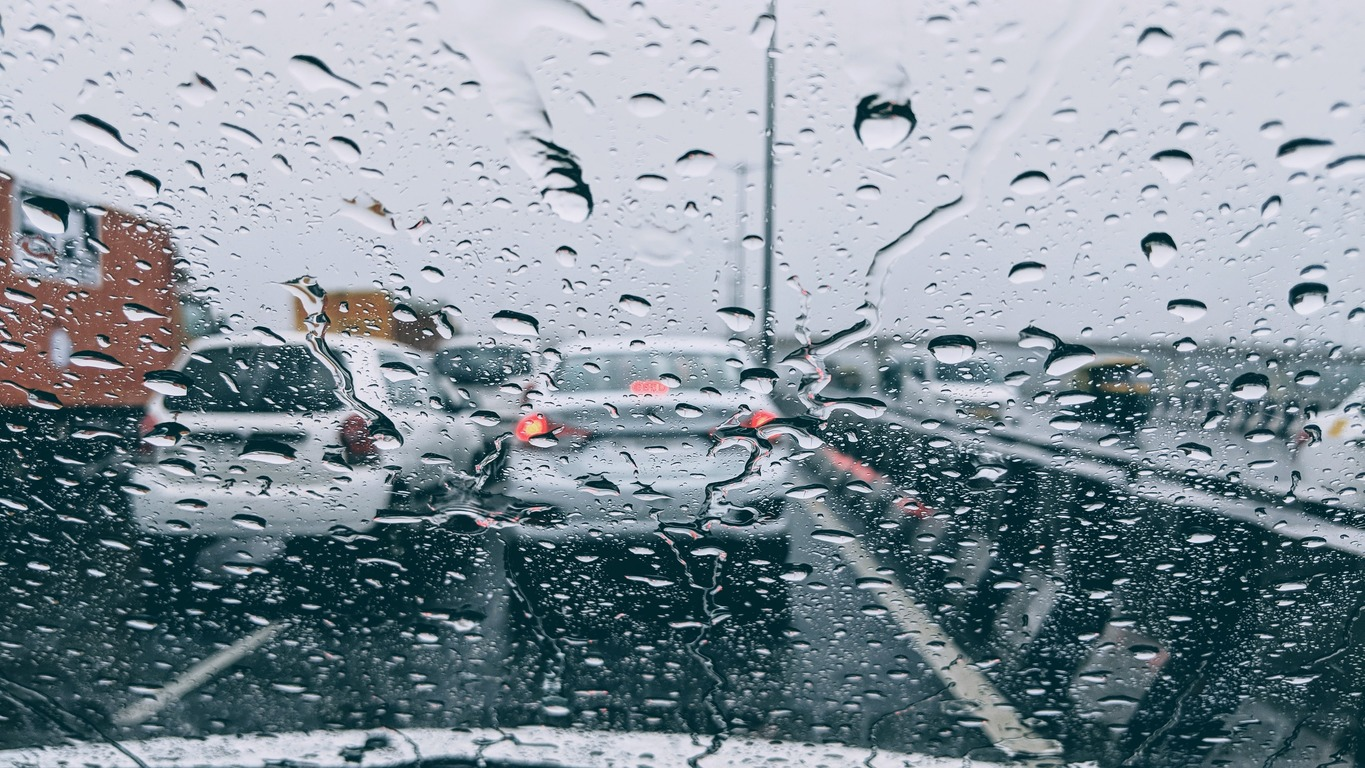

In this project, we're going to analyze a dataset about the westbound traffic on the [I-94 Interstate highway](https://en.wikipedia.org/wiki/Interstate_94) 
connecting the Great Lakes and northern Great Plains regions of the U.S. The dataset was made available by John Hogue and can be downloaded from [this repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

The goal of our analysis is to determine a few indicators of heavy traffic on I-94, such as weather type, day of the week, hour, etc.
### Summary of Results
We found out that the traffic is most intense in the daytime, warm months, and business days, especially  6.00-8.00 and 16.00-17.00. Temperature doesn't influence traffic intensity, while some relatively light weather conditions do. The lowest average traffic volume is related to 2016, followed by the maximum peak in 2017. The New Year holidays are characterized by the heaviest traffic of all the holidays.
## Dataset Downloading and Initial Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
print(f'Number of rows:\t\t  {traffic.shape[0]:,}'
      f'\nNumber of columns: \t  {traffic.shape[1]:,}'
      f'\nNumber of missing values: {traffic.isnull().sum().sum()}'
      f'\n\nCOLUMN NAMES: \n{traffic.columns.to_list()}'
      f'\n\nDATA TYPES: \n{traffic.dtypes}')

Number of rows:		  48,204
Number of columns: 	  9
Number of missing values: 0

COLUMN NAMES: 
['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description', 'date_time', 'traffic_volume']

DATA TYPES: 
holiday                 object
temp                   float64
rain_1h                float64
snow_1h                float64
clouds_all               int64
weather_main            object
weather_description     object
date_time               object
traffic_volume           int64
dtype: object


There are 48,204 entries and 9 columns in the dataset, and no NaN values. The column `holiday` seems to contain a lot of 'None' values, though. Below are the descriptions of each column from the documentation:
- `holiday` – US National holidays plus regional holiday, Minnesota State Fair,
- `temp` – average temp in kelvin,
- `rain_1h` – the amount in mm of rain that occurred in the hour,
- `snow_1h` – the amount in mm of snow that occurred in the hour,
- `clouds_all` – % of cloud cover,
- `weather_main` – a short textual description of the current weather,
- `weather_description` – a longer textual description of the current weather,
- `date_time` – the time of the data collected in local CST time,
- `traffic_volume` – hourly I-94 ATR 301 reported westbound traffic volume.

##  Analyzing Traffic Volume
The [dataset documentation](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume) mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records cars moving from east to west.

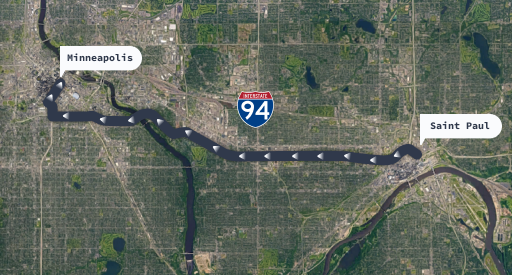

This means that the results of our analysis will be about the westbound traffic in the proximity of that station, so we should avoid generalizing our results for the entire I-94 highway.

Let's plot the distribution of traffic volume:

count    48204.0
mean      3260.0
std       1987.0
min          0.0
25%       1193.0
50%       3380.0
75%       4933.0
max       7280.0
Name: traffic_volume, dtype: float64

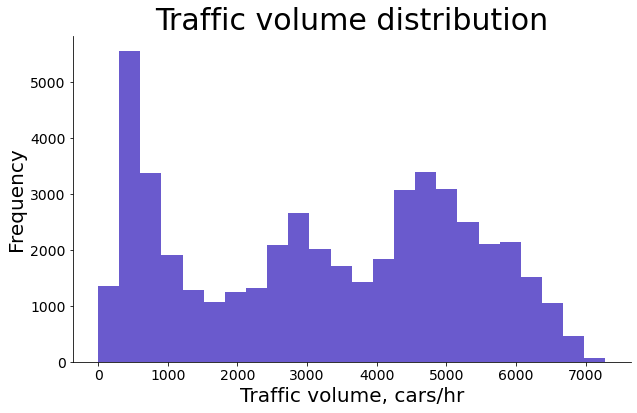

In [4]:
plt.figure(figsize=(10,6))

def create_hist(df, bins, color, title, title_font, axis_font, tick_font):
    plt.hist(df['traffic_volume'], bins=bins, color=color)
    plt.title(title, fontsize=title_font)
    plt.xlabel('Traffic volume, cars/hr', fontsize=axis_font)
    plt.ylabel('Frequency', fontsize=axis_font)
    plt.xticks(fontsize=tick_font)
    plt.yticks(fontsize=tick_font)
    sns.despine()

# Plotting the overall distribution of traffic volume
create_hist(df=traffic, bins=24, color='slateblue',
            title='Traffic volume distribution',
            title_font=30, axis_font=20, tick_font=14)
            
round(traffic['traffic_volume'].describe())

Some observations here:
- The distribution is multimodal slightly right-skewed, with 3 peaks: approximately 500, 3,000, and 5,000 cars/hr. 
- Overall, the number of cars per hour varies from 0 to 7,280, with an average of 3,260 cars/hr. 
- The most frequent values of traffic volume range from 300 to 1,000, from 2,500 to 3,500, and from 4,500 to 6,300. 
- About 25% of the time, 1,193 or fewer cars were passing the station each hour.
- About 25% of the time, 4,933 or more cars were passing the station each hour.

At this point, we can assume that traffic volume is strongly influenced by daytime and nighttime. In particular, in the daytime, most probably, there are distinct periods of moderate traffic (related to working hours) and heavy traffic with traffic jams (related to the morning and evening hours when people usually go to or from work). So, let's compare daytime with nighttime data.
## Traffic Volume: Day vs. Night
We'll start by dividing the dataset into two parts:
- Daytime data: from 7 a.m. to 7 p.m. (12 hours).
- Nighttime data: from 7 p.m. to 7 a.m. (12 hours).

While this is not a perfect criterion for distinguishing between nighttime and daytime, it's a good starting point.

In [5]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

# Dividing the dataset into daytime and nighttime subsets
day = traffic.copy()[(traffic['date_time'].dt.hour>=7)&(traffic['date_time'].dt.hour<19)]
night = traffic.copy()[(traffic['date_time'].dt.hour<7)|(traffic['date_time'].dt.hour>=19)]

Now, we're going to compare traffic volume at night and during the day:

DAYTIME STATS:
count    23877.0
mean      4762.0
std       1175.0
min          0.0
25%       4252.0
50%       4820.0
75%       5559.0
max       7280.0
Name: traffic_volume, dtype: float64

NIGHTTIME STATS:
count    24327.0
mean      1785.0
std       1442.0
min          0.0
25%        530.0
50%       1287.0
75%       2819.0
max       6386.0
Name: traffic_volume, dtype: float64



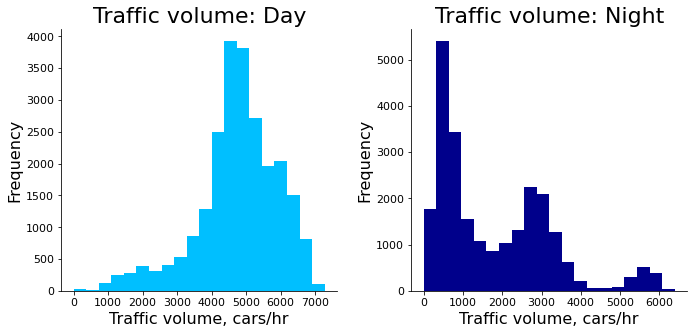

In [6]:
dfs = [day, night]
titles = ['Traffic volume: Day', 'Traffic volume: Night']
colors = ['deepskyblue', 'darkblue']

# Plotting the distributions of traffic volume at night and during the day
plt.figure(figsize=(10,5))
for i in range(1,3):
    plt.subplot(1, 2, i)
    create_hist(df=dfs[i-1], bins=20, color=colors[i-1], title=titles[i-1],
                title_font=22, axis_font=16, tick_font=11)
plt.tight_layout(pad=2)

day_stats = round(day['traffic_volume'].describe())
night_stats = round(night['traffic_volume'].describe())

print(f'DAYTIME STATS:'
      f'\n{day_stats}'
      f'\n\nNIGHTTIME STATS:'
      f'\n{night_stats}\n')

Let's analyze the features for daytime and nighttime separately.

**Daytime:**
- The distribution for daytime is unimodal left-skewed.
- The majority of traffic volume values lie between 4,000 and 6,500 cars/hr, with an average of 4,762 cars/hr. 
- About 25% of the daytime, traffic volume was 4,252 cars/hr or lower. 
- On the other hand, about 25% of the daytime, it was 5,559 cars/hr or higher.

**Nighttime:**
- The distribution for nighttime is multimodal right-skewed, with 3 peaks: approximately 500 (the highest peak), 3,000, and 5,500 (the lowest peak) cars/hr. This form of distribution is responsible for the multimodal distribution with 3 peaks that we saw earlier, in particular, for its leftmost two peaks. 
- The majority of traffic volume values lie between 0 and 1,000 cars/hr, and, secondarily, between 2,500 and 3,500 cars/hr, with an average of 1,785, which is 2.7 times lower than that for daytime. 
- About 25% of the nighttime, the traffic volume was 530 cars/hr or lower. 
- On the other hand, about 25% of the daytime, it was 2,819 cars/hr or higher.
- The multimodal form of distribution is, most probably, due to the fact that what we considered as "night" is indeed quite heterogeneous: from 7 p.m. till 7.a.m., we actually have:
    - a  short period of time prone to traffic jams, when many people return from work,
    - a period of very light traffic at deep night,
    - something in between, including the early morning time.
    
All in all, from the histograms above, we can conclude that in general, the night traffic is much less intense than that of daytime. Since our goal is to find indicators of *heavy* traffic, let's focus on the daytime.
## Time Indicators
One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain hour.

Let's check how traffic volume changed by different time units: year, month, day of the week, or hour.
### Traffic Volume by Year

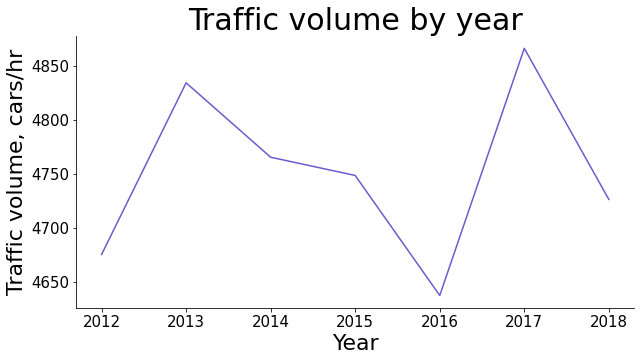

In [7]:
day['year'] = day['date_time'].dt.year
by_year = day.groupby('year').mean()

def create_line_plot(df, title, xlabel, tick_min=None, tick_max=None, labels=None,
                     xmin=None, xmax=None, ymin=None, ymax=None, 
                     title_font=30, color='slateblue', 
                     linestyle=None, marker=None, rotation=None):
    plt.plot(df['traffic_volume'], color=color, linestyle=linestyle, marker=marker)
    plt.title(title, fontsize=title_font)
    plt.xlabel(xlabel, fontsize=22)
    plt.ylabel('Traffic volume, cars/hr', fontsize=22)
    if tick_max:
        ticks=[i for i in range(tick_min, tick_max+1)]
    else:
        ticks=None
    plt.xticks(ticks=ticks, labels=labels, fontsize=15, rotation=rotation)
    plt.yticks(fontsize=15)
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    sns.despine()

# Plotting traffic volume by year
plt.figure(figsize=(10,5))
create_line_plot(df=by_year,
                 title='Traffic volume by year', xlabel='Year')

The lowest traffic volume is related to 2016, followed by the maximum peak in 2017. One possible explanation here is that in 2016, there were some global road works ongoing that caused temporary traffic volume reduction. Probably they were expanding the road which resulted in a traffic volume increase the year after.
### Traffic Volume by Month

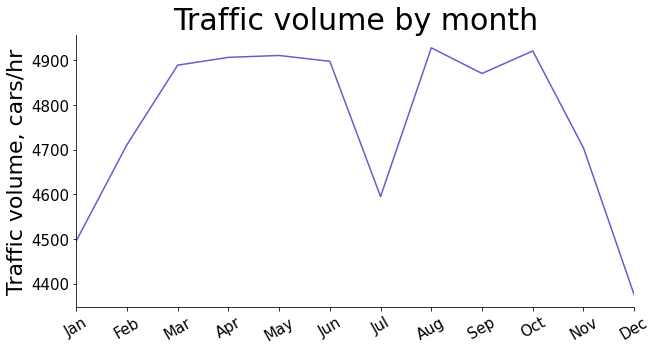

In [8]:
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()

# Plotting traffic volume by month
plt.figure(figsize=(10,5))
create_line_plot(df=by_month,
                 title='Traffic volume by month', xlabel=None,
                 tick_min=1, tick_max=12,
                 labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                 xmin=1, xmax=12,
                 rotation=30)

We see that in general, the traffic is much less intense in cold months (November-February). However, we can observe a sharp traffic volume decrease also in July, which looks curious. Let's try to figure out the reason for it and check the traffic volume of this month by year.

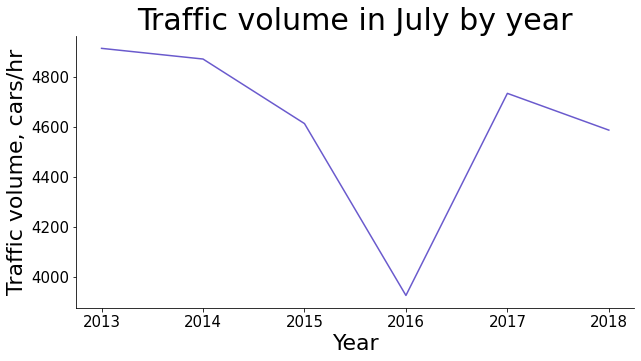

In [9]:
july = day[day['month']==7].groupby('year').mean()

# Plotting traffic volume in July by year
plt.figure(figsize=(10,5))
create_line_plot(df=july,
                 title='Traffic volume in July by year', xlabel='Year')

We can state that the decrease derives only from the year 2016, which we've already distinguished earlier as a year of the lowest traffic volume.  All the other years show quite high values of traffic volume for July, just as we saw earlier for the other warm months. Our assumption about global road works in 2016 seems more realistic now.
### Traffic Volume by Day of the Week

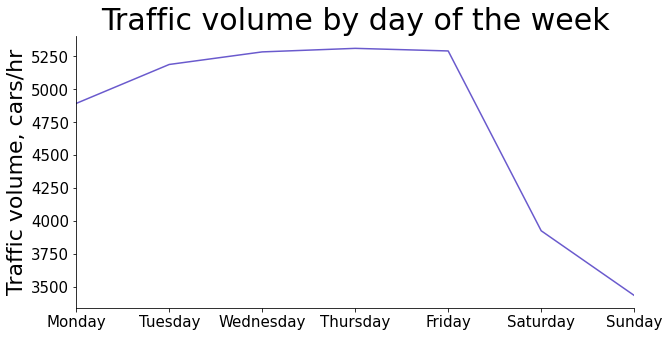

In [10]:
day['day_of_week'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('day_of_week').mean()

# Plotting traffic volume by day of the week
plt.figure(figsize=(10,5))
create_line_plot(df=by_dayofweek,
                 title='Traffic volume by day of the week', xlabel=None,
                 tick_min=0, tick_max=6,
                 xmin=0, xmax=6,
                 labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

We observe a considerable difference between the average traffic volume on business days, usually exceeding 5,000 cars/hr, and that on weekends, especially on Sunday (less than 3,500 cars/hr).
### Traffic Volume by Hour
To analyze traffic volume by hour, we should take into account that the weekends would drag down the average values. Hence, it makes sense to look at the averages separately for business days and weekends.

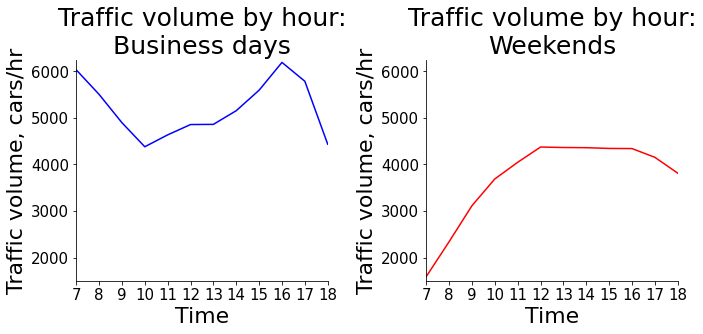

In [11]:
day['hour'] = day['date_time'].dt.hour
bussiness_days = day.copy()[day['day_of_week']<=4]    # 4 == Friday
weekend = day.copy()[day['day_of_week']>=5]           # 5 == Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

dfs = [by_hour_business, by_hour_weekend]
titles = ['Traffic volume by hour:\nBusiness days', 'Traffic volume by hour:\nWeekends']
colors = ['blue', 'red']

# Plotting traffic volume by hour
plt.figure(figsize=(10,5))
for i in range(1,3):
    plt.subplot(1, 2, i)
    create_line_plot(df=dfs[i-1],
                     title=titles[i-1], xlabel='Time',
                     tick_min=7, tick_max=18,
                     xmin=7, xmax=18, ymin=1500, ymax=6250,
                     title_font=25, color=colors[i-1])
plt.tight_layout(pad=2)

The traffic is heavier on business days for almost all daytime hours with respect to weekends. For business days, there are 2 clear peaks: 7.00-8.00 and 16.00-17.00, both related to rush hours when people go to work and back. As for weekends, there are no peaks on the plot, and the traffic gradually increases from 7 a.m. till 12 a.m., when it reaches a plateau and from 16.00 starts decreasing.

All in all, we found the following time indicators of more intense traffic:
- warm months,
- business days,
- time:
    - 7.00-8.00 and 16.00-17.00 on business days, 
    - 12.00-16.00 on weekends.
    
In addition, we discovered a sharp traffic volume reduction in 2016, presumably due to road expansion works, followed by the highest peak in 2017.    
## Weather Indicators
Another possible indicator of heavy traffic is the weather. We can find information about the weather in the following columns: `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, `weather_description`. The first 4 of them are numerical, so let's try to figure out how they correlate with `traffic_volume`.

In [12]:
round(day.corr()['traffic_volume'][['temp', 'rain_1h', 'snow_1h', 'clouds_all']], 3)

temp          0.128
rain_1h       0.004
snow_1h       0.001
clouds_all   -0.033
Name: traffic_volume, dtype: float64

Temperature shows the strongest correlation (even though very low anyway) with traffic volume. Let's plot these two variables against each other:

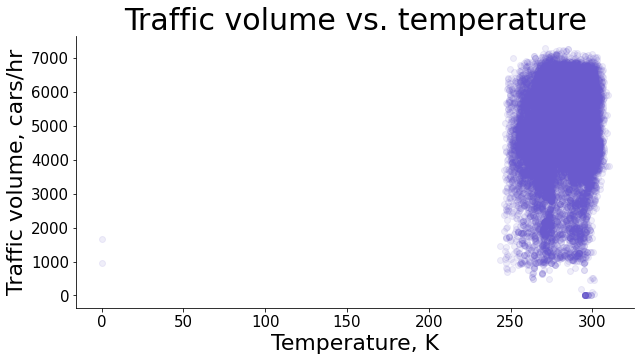

In [13]:
def create_scatter_plot(df, column, title, xlabel, xmin=None, xmax=None):
    plt.figure(figsize=(10,5))
    plt.scatter(df[column], df['traffic_volume'], color='slateblue', alpha=0.1)
    plt.title(title, fontsize=30)
    plt.xlabel(xlabel, fontsize=22)
    plt.ylabel('Traffic volume, cars/hr', fontsize=22)
    plt.xlim(xmin,xmax)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    sns.despine()

# Plotting traffic volume vs. temperature
create_scatter_plot(df=day, column='temp',
                    title='Traffic volume vs. temperature',
                    xlabel='Temperature, K')

There are 2 wrong values of temperature to be ignored.

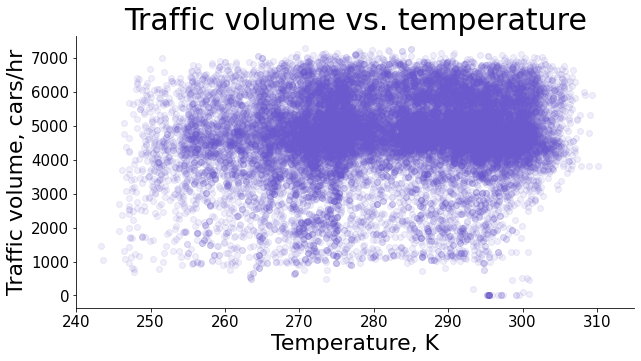

In [14]:
create_scatter_plot(df=day, column='temp',
                    title='Traffic volume vs. temperature',
                    xlabel='Temperature, K', xmin=240, xmax=315)

Now we can conclude that actually there is no valid correlation between temperature and traffic volume, meaning that temperature isn't a reliable indicator for heavy traffic, not to mention other 3 numerical weather columns (`rain_1h`, `snow_1h`, and `clouds_all`) that showed very lower Pearson correlation coefficient. To see if we can find more useful data, we'll look next at the categorical weather columns: `weather_main` and `weather_description`.
## Weather Types
We're going to calculate and plot the average traffic volume associated with each weather type, i.e. each unique value in the columns `weather_main` and `weather_description`.

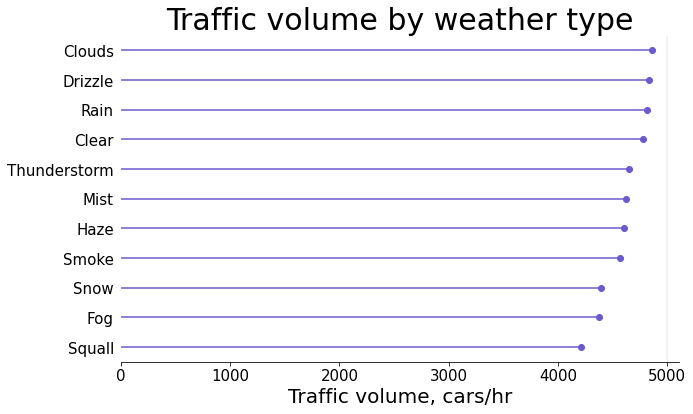

In [15]:
by_weather_main = day.groupby('weather_main').mean().sort_values('traffic_volume')
by_weather_description = day.groupby('weather_description').mean().sort_values('traffic_volume')

def create_stem_plot(df, fig_height,
                     title='Traffic volume by weather type',
                     ymin=None, ymax=None, vert_line=5000):
    plt.figure(figsize=(10,fig_height))
    plt.hlines(y=df.index,
               xmin=0, xmax=df['traffic_volume'],
               color='slateblue')
    plt.plot(df['traffic_volume'], df.index,
             'o', c='slateblue')
    plt.title(title, fontsize=30)
    plt.xlabel('Traffic volume, cars/hr', fontsize=20)
    plt.ylabel(None)
    plt.xlim(0,None)
    plt.ylim(ymin,ymax)
    plt.tick_params(left=False)
    plt.axvline(x=vert_line, color='grey', linewidth=0.2)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    sns.despine(left=True)

# Plotting traffic volume by weather type
create_stem_plot(df=by_weather_main, fig_height=6)

There are no weather types where traffic volume exceeds 5,000 cars/hr, so we cannot identify any heavy traffic indicator from the `weather_main` column. Let's plot the results for the `weather_description` column instead:

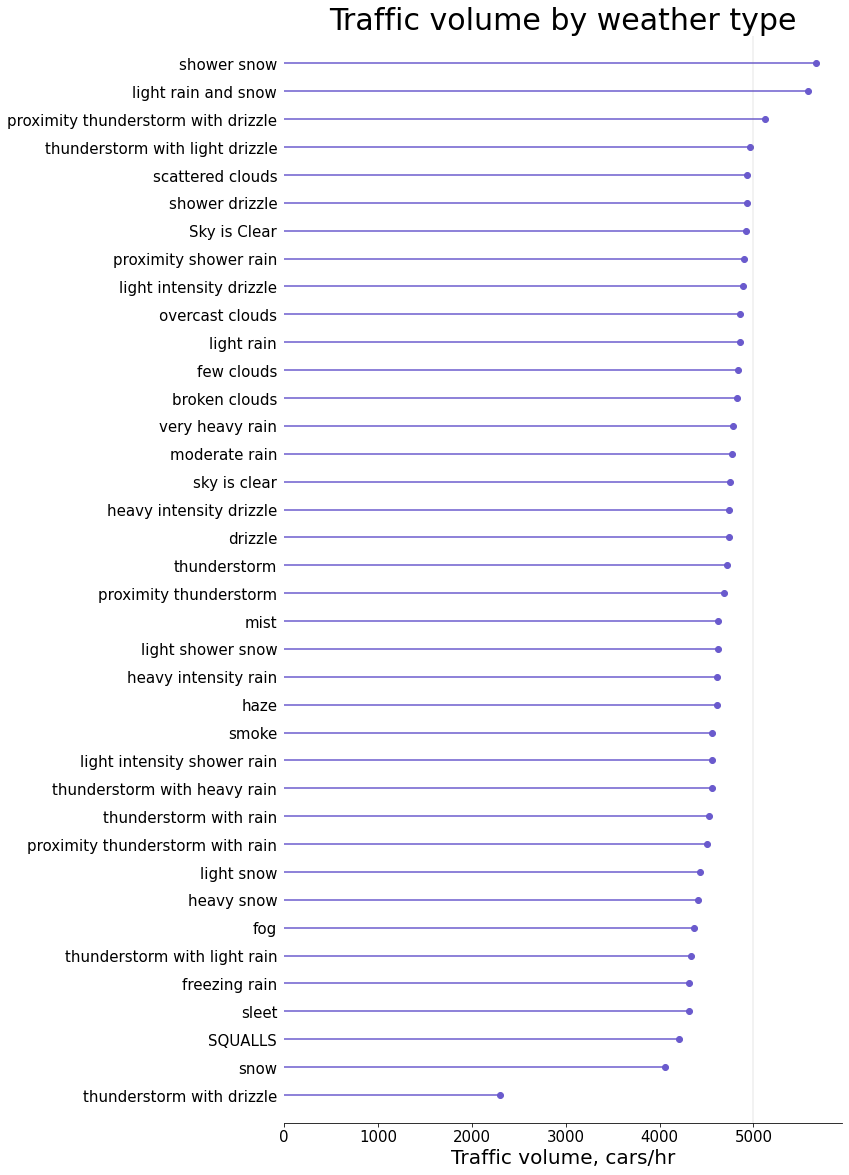

In [16]:
# Plotting traffic volume by weather type (detailed)
create_stem_plot(df=by_weather_description, fig_height=20,
                 ymin=-1, ymax=38)

In this case, we can identify the following 3 weather types that led to heavy traffic of more than 5,000 cars/hr:
- shower snow,
- light rain and snow,
- proximity thunderstorm with drizzle.

The results look surprising: evidently, there are many other weather types in the dataset representing much worse weather where traffic is much lighter. One possible explanation here is that really bad weather conditions (thunderstorms, very heavy rain, squalls, etc.) are usually forecast in advance, so people try to do their best not to travel by car on such days.
## Nighttime Traffic Analysis
Earlier we concluded that the nighttime traffic is much lighter than that of daytime, and since our goal was to find indicators of heavy traffic, we focused on the daytime only. Now that we've already figured out the main influencing factors, let's return to the nighttime traffic and check its overall trends with respect to different time and weather indicators discussed above:

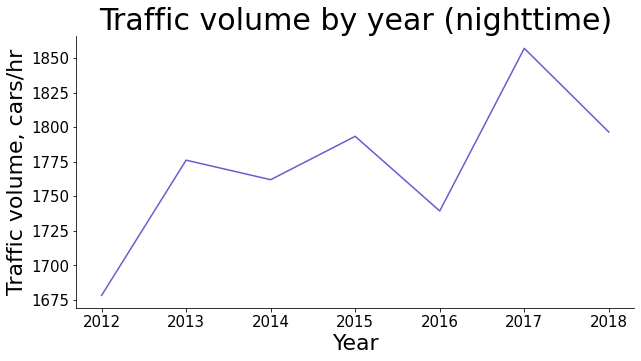

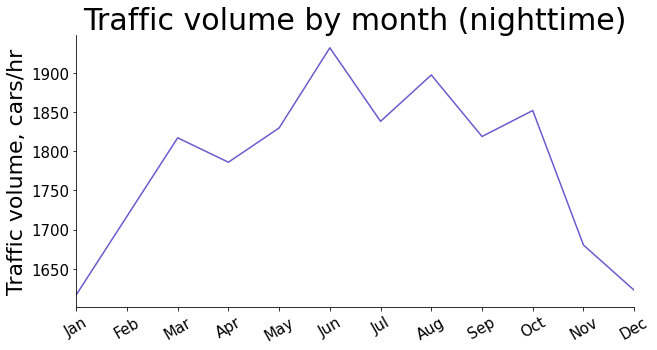

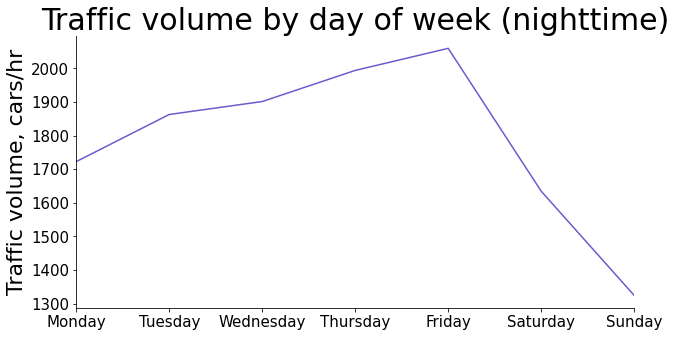

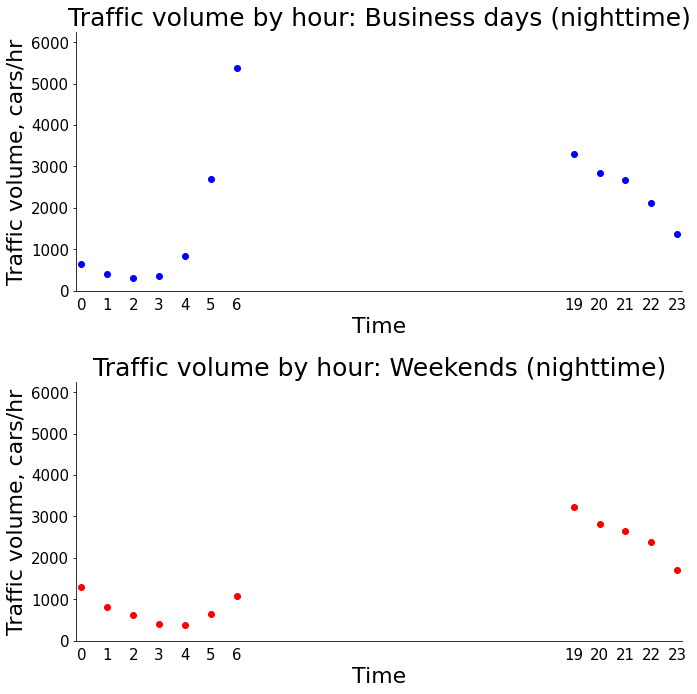



temp          0.094
rain_1h      -0.013
snow_1h      -0.007
clouds_all    0.013
Name: traffic_volume, dtype: float64




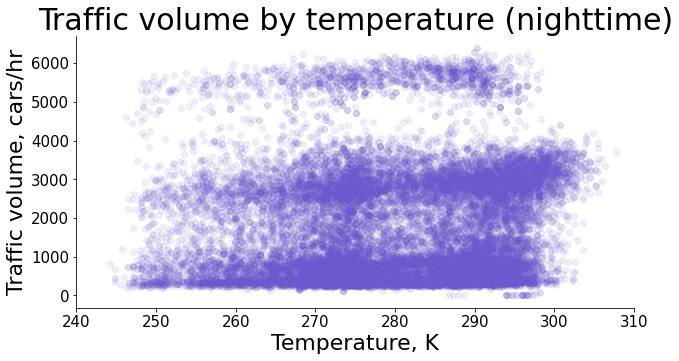

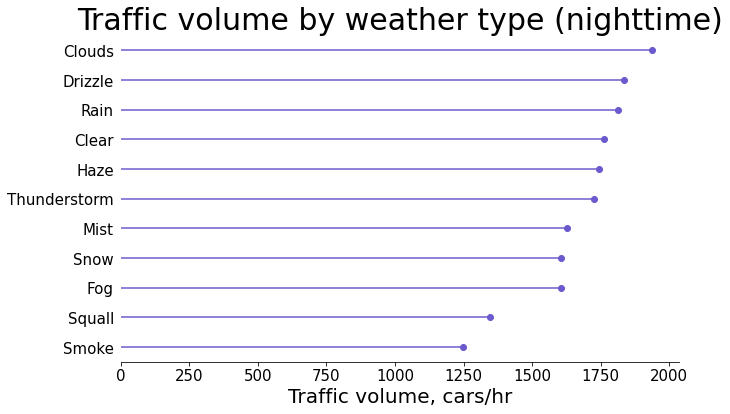

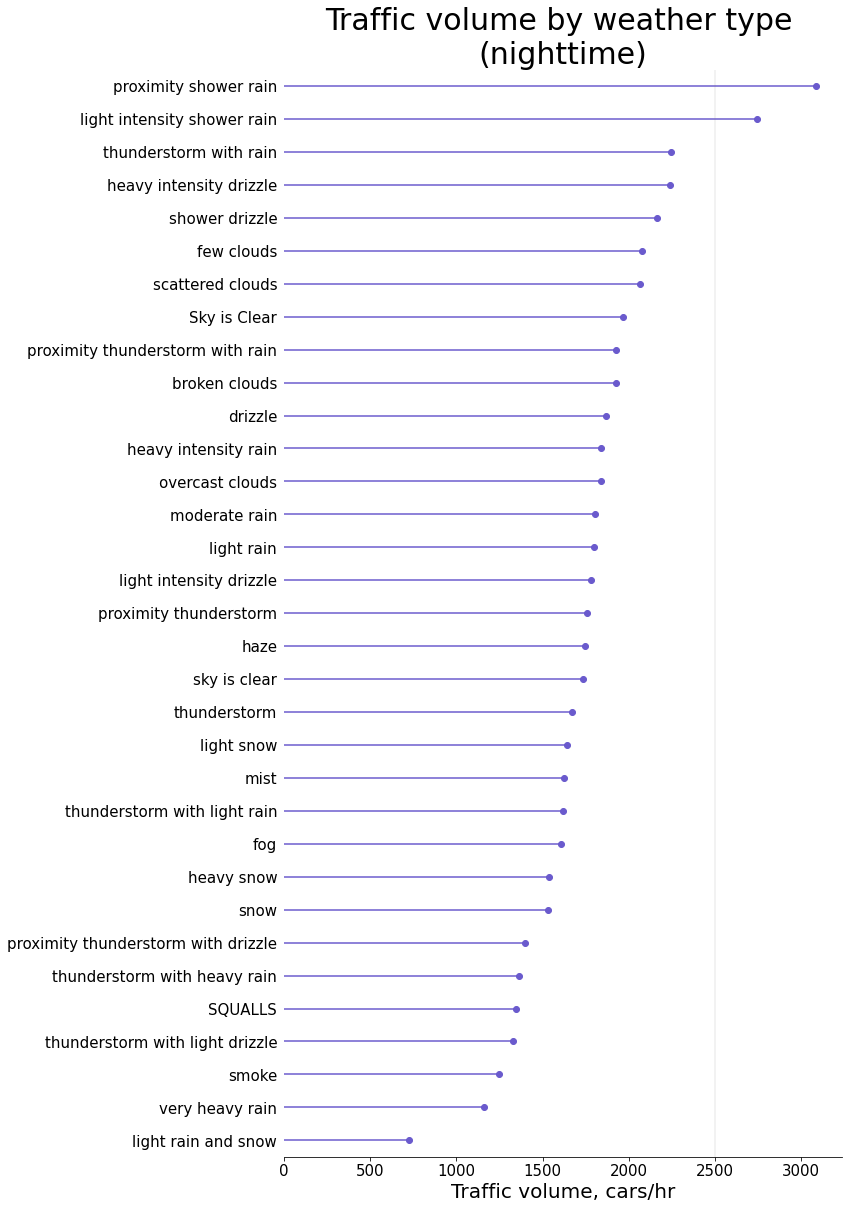

In [17]:
# Calculating and plotting nighttime traffic volume by different indicators
#____________________________________________________
# By year
night['year'] = night['date_time'].dt.year
by_year_night = night.groupby('year').mean()

plt.figure(figsize=(10,5))
create_line_plot(df=by_year_night,
                 title='Traffic volume by year (nighttime)', xlabel='Year')
plt.show()
print('\n')
#____________________________________________________
# By month
night['month'] = night['date_time'].dt.month
by_month_night = night.groupby('month').mean()
plt.figure(figsize=(10,5))
create_line_plot(df=by_month_night,
                 title='Traffic volume by month (nighttime)', xlabel=None,
                 tick_min=1, tick_max=12,
                 labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                 rotation=30,
                 xmin=1, xmax=12)
plt.show()
print('\n')
#____________________________________________________
# By day of the week
night['day_of_week'] = night['date_time'].dt.dayofweek
by_dayofweek_night = night.groupby('day_of_week').mean()
plt.figure(figsize=(10,5))
create_line_plot(df=by_dayofweek_night,
                 title='Traffic volume by day of the week (nighttime)', xlabel=None,
                 tick_min=0, tick_max=6,
                 xmin=0, xmax=6,
                 labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()
print('\n')
#____________________________________________________
# By hour
night['hour'] = night['date_time'].dt.hour
bussiness_days_night = night.copy()[night['day_of_week']<=4] # 4 == Friday
weekend_night = night.copy()[night['day_of_week']>=5] # 5 == Saturday
by_hour_business_night = bussiness_days_night.groupby('hour').mean()
by_hour_weekend_night = weekend_night.groupby('hour').mean()

dfs_night = [by_hour_business_night, by_hour_weekend_night]
titles_night = ['Traffic volume by hour: Business days (nighttime)', 'Traffic volume by hour: Weekends (nighttime)']
colors = ['blue', 'red']

plt.figure(figsize=(10,10))
for i in range(1,3):
    plt.subplot(2, 1, i)
    create_line_plot(df=dfs_night[i-1],
                     title=titles_night[i-1], xlabel='Time',
                     tick_min=0, tick_max=23,
                     labels=['0','1', '2', '3', '4', '5', '6', '', '', '', '', '', '', '', '', '', '', '', '', '19', '20','21','22','23'],
                     xmin=-0.2, xmax=23.2,
                     ymin=0, ymax=6250,
                     title_font=25, color=colors[i-1], linestyle=' ', marker='o')
    plt.tick_params(bottom=False)
plt.tight_layout(pad=2)
plt.show()
print('\n')
#_______________________________________________________
# By temperature
print(round(night.corr()['traffic_volume'][['temp', 'rain_1h', 'snow_1h', 'clouds_all']], 3))
print('\n')
create_scatter_plot(df=night, column='temp',
                    title='Traffic volume by temperature (nighttime)',
                    xlabel='Temperature, K', xmin=240, xmax=310)
plt.show()
print('\n')
#_______________________________________________________
# By weather type
by_weather_main_night = night.groupby('weather_main').mean().sort_values('traffic_volume')
by_weather_description_night = night.groupby('weather_description').mean().sort_values('traffic_volume')

create_stem_plot(df=by_weather_main_night, fig_height=6,
                 title='Traffic volume by weather type (nighttime)')
plt.show()
print('\n')
create_stem_plot(df=by_weather_description_night, fig_height=20,
                 title='Traffic volume by weather type \n(nighttime)',
                 ymin=-0.5, ymax=32.5, vert_line=2500)

Even though the absolute values of traffic volume are much smaller for the nighttime, we can observe some already familiar tendencies:
- A traffic volume decrease in 2016 with subsequent growth in 2017.
- Less intense traffic in cold months (November-February).
- Considerably less intense traffic on weekends.
- On business days, traffic gradually decreases from 19 till 2 a.m, then rapidly increases from 4 till 6 a.m. On weekends, the traffic reaches its minimum later, at 3 a.m. From 4 a.m. till 6 a.m. it increases again, but slightly.
- Temperature doesn't influence traffic intensity, despite the strongest (relatively) Pearson correlation coefficient.
- 2 weather types can contribute to relatively more intense (> 2,500 cars/hr) traffic at night:
    - proximity shower rain,
    - light intensity shower rain.
    
As in the case of daytime, these weather types are not that bad, but probably not much forecast in advance as seriously bad weather conditions, so they cannot prevent people from traveling by car. 
## Traffic Volume on Holidays
Finally, let's explore traffic intensity on holidays:

In [18]:
print(f"{traffic[traffic['holiday']!='None']['holiday'].nunique()} unique holidays in the dataset:\n"
      f"{list(traffic[traffic['holiday']!='None']['holiday'].unique())}\n\n"
      f"{len(traffic[traffic['holiday']!='None'])} entries for all the holidays\n\n"
      f"The trips on holidays happened at the following hours: {list(traffic[traffic['holiday']!='None']['date_time'].dt.hour.unique())} ")

11 unique holidays in the dataset:
['Columbus Day', 'Veterans Day', 'Thanksgiving Day', 'Christmas Day', 'New Years Day', 'Washingtons Birthday', 'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day', 'Martin Luther King Jr Day']

61 entries for all the holidays

The trips on holidays happened at the following hours: [0] 


A curious thing is that all 61 holiday trips were registered at midnight, like Cinderella's style! 😃 It seems to be a technical issue to be fixed, or just in the majority of cases, the holiday was not noted. Anyway, we cannot use this dataset to analyze holiday trips by daytime or nighttime. Besides, 61 entries are not that many. Hence, let's analyze them all together:

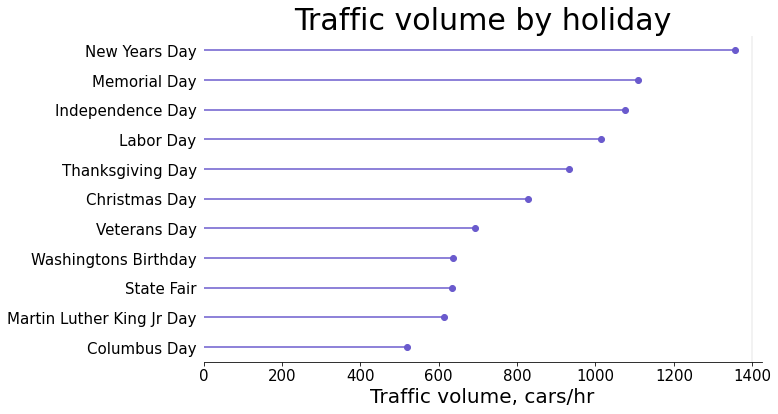

In [19]:
by_holiday = night[night['holiday']!='None'].groupby('holiday').mean().sort_values('traffic_volume')

# Plotting traffic volume by holiday
create_stem_plot(df=by_holiday, fig_height=6, vert_line=1400,
                 title='Traffic volume by holiday')

We can't see any particularly high values of traffic volume on holidays for the data available. The most intense traffic (~1400 cars/hr) is related to the New Year holidays, followed with a big gap by Memorial, Independence, and Labor Days.
## Conclusion
In this project, we analyzed the data on the westbound traffic on the I-94 Interstate highway of the U.S., registered by a station midway between Minneapolis and Saint Paul, with the goal to determine a few indicators of heavy traffic on this part of the road. Below are the most important insights:
- Time periods prone to **more intense traffic**:
    - daytime (7.00-19.00),
    - warm months,
    - business days, especially from 6.00 till 8.00 and from 16.00 till 17.00.
- The lowest average traffic volume is related to 2016, followed by the maximum peak in 2017, presumably explained by road expansion works in 2016.
- Temperature doesn't influence traffic intensity.
- Weather types leading to heavy traffic (>5,000 cars/hr) *in the daytime*:
    - shower snow,
    - light rain and snow,
    - proximity thunderstorm with drizzle.
- Weather types leading to relatively heavy traffic (> 2,500 cars/hr) *in the nighttime*:
    - proximity shower rain,
    - light intensity shower rain.

All these weather conditions are not that bad, but probably not much forecast in advance as really bad ones, so they cannot prevent people from traveling by car.
- The New Year holidays are characterized by the most intense traffic compared to the other holidays.